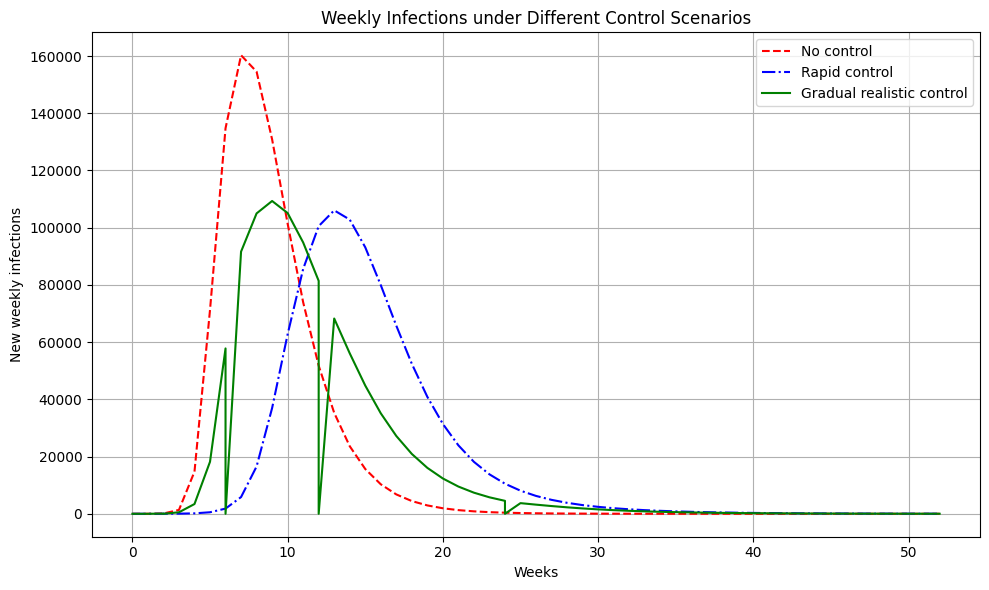

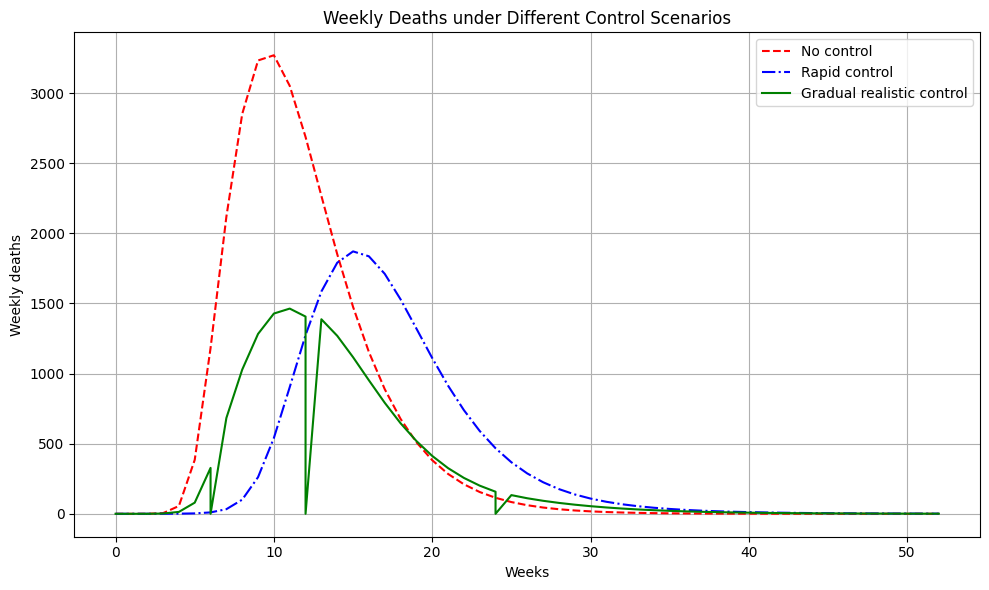

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from model import Params, ControlGains, simulate

# =====================================================
# TIME SETTINGS
# =====================================================
weeks = np.linspace(0, 52, 53)  # 1 year (weekly)
N = 1_000_000  # total population (example)

# Initial conditions: S, E, I, R, C, cumulative cases, cumulative deaths
y0 = (N - 10, 10, 0, 0, 0, 0, 0)

# Base parameters (do NOT modify the equations)
params_base = Params(
    N=N, beta1=0.8, beta2=0.6, sigma=1/2,
    gamma=1/3, mu=0.01, delta=0.2, eta=0.4,
    epsilon=0.05, kappa=5000
)
gains = ControlGains()

# =====================================================
# 1️⃣ BASELINE — No intervention
# =====================================================
params = params_base
params.u_san = 0.0     # sanitation control
params.u_vac = 0.0     # vaccination
params.u_treat = 0.0   # water treatment

out_base = simulate(weeks, y0, params, gains)

# =====================================================
# 2️⃣ RAPID INTERVENTION — Immediate response
# =====================================================
params = params_base
params.u_san = 0.6
params.u_vac = 0.0
params.u_treat = 0.1

out_fast = simulate(weeks, y0, params, gains)

# =====================================================
# 3️⃣ GRADUAL REALISTIC CONTROL — Progressive increase
# =====================================================
segments = [(0, 2), (2, 6), (6, 12), (12, 24), (24, 52)]
schedule = {
    (0, 2):   {"u_san": 0.1, "u_vac": 0.0,  "u_treat": 0.05},  # initial chaos
    (2, 6):   {"u_san": 0.3, "u_vac": 0.0,  "u_treat": 0.10},  # local efforts begin
    (6, 12):  {"u_san": 0.5, "u_vac": 0.1,  "u_treat": 0.20},  # international aid
    (12, 24): {"u_san": 0.4, "u_vac": 0.1,  "u_treat": 0.15},  # partial stability
    (24, 52): {"u_san": 0.25,"u_vac": 0.05, "u_treat": 0.10},  # decline in support
}

y_init = y0
weeks_total = []
weekly_cases_total = []
weekly_deaths_total = []

for (start, end) in segments:
    t_seg = np.linspace(start, end, int(end-start)+1)
    ctrl = schedule[(start, end)]
    params = params_base
    params.u_san = ctrl["u_san"]
    params.u_vac = ctrl["u_vac"]
    params.u_treat = ctrl["u_treat"]

    out = simulate(t_seg, y_init, params, gains)

    # Save results
    weeks_total.extend(out["t"])
    weekly_cases_total.extend(out["weekly_cases"])
    weekly_deaths_total.extend(out["weekly_deaths"])

    # Update initial condition for next phase
    y_init = (out["S"][-1], out["E"][-1], out["I"][-1],
              out["R"][-1], out["C"][-1],
              out["cum_inc"][-1], out["cum_deaths"][-1])

# Convert to arrays
weeks_total = np.array(weeks_total)
weekly_cases_total = np.array(weekly_cases_total)
weekly_deaths_total = np.array(weekly_deaths_total)

# =====================================================
# 📊 Weekly infections comparison
# =====================================================
plt.figure(figsize=(10, 6))
plt.plot(out_base["t"], out_base["weekly_cases"], 'r--', label="No control")
plt.plot(out_fast["t"], out_fast["weekly_cases"], 'b-.', label="Rapid control")
plt.plot(weeks_total, weekly_cases_total, 'g', label="Gradual realistic control")

plt.title("Weekly Infections under Different Control Scenarios")
plt.xlabel("Weeks")
plt.ylabel("New weekly infections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# 📉 Weekly deaths comparison
# =====================================================
plt.figure(figsize=(10, 6))
plt.plot(out_base["t"], out_base["weekly_deaths"], 'r--', label="No control")
plt.plot(out_fast["t"], out_fast["weekly_deaths"], 'b-.', label="Rapid control")
plt.plot(weeks_total, weekly_deaths_total, 'g', label="Gradual realistic control")

plt.title("Weekly Deaths under Different Control Scenarios")
plt.xlabel("Weeks")
plt.ylabel("Weekly deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
